<a href="https://colab.research.google.com/github/neelabhro/Deep-Learning-based-Wireless-Communications/blob/main/Semantic_PathLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import libraries

In [99]:
# magic command to use TF 1.X in colaboraty when importing tensorflow
%tensorflow_version 1.x 
import tensorflow as tf                       # imports the tensorflow library to the python kernel
tf.logging.set_verbosity(tf.logging.ERROR)    # sets the amount of debug information from TF (INFO, WARNING, ERROR)
import time
import random
print("Using tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Using tensorflow version: 1.15.2


In [100]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import math
pi = tf.constant(math.pi)

#### System parameters

In [101]:
batch_size = 1000
########## BIT FLIPPING ON
#print(tr)
#plt.plot(t, tr)
T1 = random.randint(1, 10)
T2 = random.randint(1, 10)
M = 8
t = np.linspace(0, 1, batch_size)
triangle1 = signal.sawtooth(T1 * np.pi * 5 * t, 0.5)
triangle1 = M/2*(triangle1)
triangle1 = triangle1.clip(min=0)

triangle2 = signal.sawtooth(T2 * np.pi * 5 * t, 0.5)
triangle2 = M/2*(triangle2)
triangle2 = triangle2.clip(min=0)

triangle3 = triangle1 + triangle2
#triangle3 = triangle3/15*(7)
tr = triangle3
bins = np.arange(M-1)
tr = np.digitize(triangle3, bins, right=True)
#plt.plot(t, triangle3)

#tr = np.flip(tr)
#print(tr)
tr = np.floor(np.random.uniform(0,M, 1000))
#print(tr)
#replacements = {0:7, 1:6, 2:5, 3:4, 4:3, 5:2, 6:1, 7:0}
#replacements = {0:15, 1:14, 2:13, 3:12, 4:11, 5:10, 6:9, 7:8, 8:7, 9:6, 10:5, 11:4, 12:3, 13:2, 14:1, 15:0}
rp1 = np.arange(M)
rp2 = np.flip(np.arange(M))
replacements = dict(zip(rp1,rp2))
#print(rp2)
replacer = replacements.get
tr = ([replacer(n, n) for n in tr])

print(tr)

s_ind = {}
for j in range(M):
  s_ind[j] = [i for i, x in enumerate(tr) if x == j]
print(s_ind)

[5, 6, 4, 6, 4, 4, 5, 5, 3, 1, 1, 4, 7, 7, 1, 7, 3, 6, 4, 1, 2, 6, 6, 6, 7, 0, 7, 7, 2, 4, 2, 6, 1, 7, 0, 6, 2, 7, 1, 7, 7, 1, 0, 5, 4, 0, 7, 0, 6, 2, 6, 2, 0, 5, 2, 4, 6, 0, 2, 3, 6, 1, 0, 1, 0, 0, 7, 5, 0, 7, 2, 1, 4, 0, 7, 6, 0, 7, 0, 2, 3, 4, 5, 6, 2, 7, 5, 3, 5, 2, 4, 1, 6, 6, 2, 7, 0, 2, 1, 2, 3, 1, 7, 1, 4, 6, 6, 3, 6, 4, 7, 0, 5, 1, 4, 2, 2, 7, 5, 7, 2, 3, 2, 1, 4, 5, 7, 7, 1, 0, 4, 7, 5, 1, 4, 6, 2, 7, 0, 3, 2, 1, 4, 5, 2, 5, 5, 3, 1, 2, 2, 5, 3, 7, 7, 2, 3, 4, 2, 5, 4, 7, 7, 1, 1, 7, 6, 6, 4, 5, 6, 3, 2, 5, 5, 2, 5, 7, 5, 1, 3, 6, 4, 6, 0, 2, 0, 0, 6, 2, 1, 2, 2, 3, 4, 7, 1, 7, 1, 3, 0, 2, 1, 7, 6, 2, 7, 2, 6, 5, 1, 7, 2, 2, 3, 1, 6, 4, 5, 1, 3, 4, 4, 7, 0, 4, 5, 3, 5, 2, 4, 5, 4, 5, 0, 4, 2, 6, 1, 4, 7, 7, 0, 6, 6, 5, 0, 3, 0, 4, 3, 3, 0, 5, 0, 3, 4, 0, 7, 6, 1, 1, 3, 4, 3, 5, 4, 4, 1, 6, 0, 2, 0, 3, 0, 7, 0, 5, 6, 2, 0, 5, 3, 2, 5, 2, 4, 3, 0, 5, 0, 5, 1, 1, 6, 1, 3, 1, 6, 5, 6, 5, 0, 1, 6, 2, 0, 1, 2, 1, 5, 6, 4, 4, 6, 5, 2, 1, 5, 7, 7, 3, 5, 6, 4, 5, 6, 4, 3, 4, 6, 6, 3, 

In [102]:
k = 3       # Number of information bits per message, i.e., M=2**k
n = 4       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results

#### The Autoencoder Class
In order to quickly experiment with different architecture and parameter choices, it is useful to create a Python class that has functions for training and inference. Each autoencoder instance has its own Tensorflow session and graph. Thus, you can have multiple instances running at the same time without interference between them.

In [103]:
f = 5.9*10**9;#in Hz corresponding to IEEE 802.11p
lamda = 0.05;  #in metres
Pt = 1; #BS transmitted power in watts
Lo = 8;   #Total system losses in dB
Nf = 5;    #Mobile receiver noise figure in dB
T = 290;   #temperature in degree kelvin
BW = 10*10**6; #in Hz
Gb = 8;  #in dB
Gm = 0;   #in dB
Hb = 1;  #in metres
Hm = 1.1;   #in metres
B = 1.38*10**-23; #Boltzmann's constant
Te = T*(3.162-1)
Pn = B*(Te+T)*BW
Free_Lp = {}
Pr = {}
SNR_var = {}
ad_noise_std = []  #The values of the dictionary, finally providing an array of stdevs




s = np.floor(np.random.uniform(0,8, 1000))
s = s.astype('int64')
s = ([replacer(n, n) for n in s])            
for i in range(1000):
  Free_Lp[i] = 20*math.log10(Hm*Hb/s[i]**2)
  Pr[i] = Free_Lp[i]-Lo+Gm+Gb+Pt  #in dBW
  SNR_var[i] = 20*math.log10(s[i] + 1) #Provides SNR (stddev) values for all distances spanning s

for i in SNR_var.values():
  ad_noise_std.append(i)

ad_noise_std = np.transpose(np.tile(ad_noise_std, (2,2,1)))



for j in range(M+1,1):

  Free_Lp[j] = 20*math.log10(Hm*Hb/j**2)
  Pr[j] = Free_Lp[j]-Lo+Gm+Gb+Pt  #in dBW
  SNR_var[j] = 20*math.log10(s[j] + 1)

const_noise_std = []  #The values of the dictionary, finally providing an array of stdevs
for j in SNR_var.values():
  const_noise_std.append(j)  
const_noise_std = np.transpose(np.tile(const_noise_std, (2,2,1)))
print(const_noise_std)


tr_noise_std = []
for i in range(1000):
  Free_Lp[i] = 20*math.log10(Hm*Hb/tr[i]**2)
  Pr[i] = Free_Lp[i]-Lo+Gm+Gb+Pt  #in dBW
  SNR_var[i] = 20*math.log10(s[i] + 1) #Provides SNR (stddev) values for all distances spanning s

for i in SNR_var.values():
  tr_noise_std.append(i)

tr_noise_std = np.transpose(np.tile(tr_noise_std, (2,2,1)))


[[[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[ 0.          0.        ]
  [ 0.          0.        ]]

 [[18.06179974 18.06179974]
  [18.06179974 18.06179974]]

 ...

 [[ 9.54242509  9.54242509]
  [ 9.54242509  9.54242509]]

 [[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[13.97940009 13.97940009]
  [13.97940009 13.97940009]]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


In [104]:

class AE(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return
    
    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,2,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            #ad_noise_std = tf.transpose(tf.tile(ad_noise_std, [2,2,1]))           
            x = self.encoder(s)                         
            
            # Channel
            #noise_std = tf.placeholder(tf.float32, shape=())
            noise_std = tf.placeholder(tf.float32, shape=[1000,2,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            #fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
            #fade = 1            
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            
            # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy_0 = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(4))
      
           # Performance metrics
            #correct_predictions_0 = tf.equal(tf.argmax(tf.nn.softmax([s_hat[x] for x in s_ind_0]), axis=1), [s[x] for x in s_ind_0])

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            #train_op_0 = tf.train.AdamOptimizer(lr).minimize(cross_entropy_0)
            #lr = tf.train.exponential_decay(1e-10, global_step=cross_entropy, decay_steps=100, decay_rate=1.30)

            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                #'s': (np.floor(np.random.uniform(0,256, 1000))).astype('int64'),
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
        }   
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self, noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
                plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    #print(self.sess.run(self.vars['s_hat'], feed_dict={self.vars['s']: s}))

    def train(self, training_params, validation_params):  
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            s,batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

## Training parameters

In [105]:
train_EbNodB = ad_noise_std
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, 1000 , 0.01, train_EbNodB, 10000]
#    [10000 , 0.001, train_EbNodB, 10000]    
    ]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [1000, val_EbNodB, 1000],
    [1000, val_EbNodB, 1000],
    [1000, val_EbNodB, 1000]
    ]

model_file_uw = 'models/ae_k_{}_n_{}'.format(k,n)
ae = AE(k,n,seed)
ae.train(training_params, validation_params)
ae.save(model_file_uw);
ae = AE(k,n,seed, filename=model_file_uw)
  #ae.plot_constellation();
  #ae.end2end(tr)

Tensor("embedding_lookup/Identity:0", shape=(?, 8), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(1000, 8), dtype=float32)

Batch Size: 1000, Learning Rate: 0.01, EbNodB: [[[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[ 0.          0.        ]
  [ 0.          0.        ]]

 [[18.06179974 18.06179974]
  [18.06179974 18.06179974]]

 ...

 [[ 9.54242509  9.54242509]
  [ 9.54242509  9.54242509]]

 [[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[13.97940009 13.97940009]
  [13.97940009 13.97940009]]], Iterations: 10000
0.717
0.058000028
0.042999983
0.050000012
0.05699998
0.050000012
0.051
0.051
0.055000007
0.049000025
Tensor("embedding_lookup/Identity:0", shape=(?, 8), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(1000, 8), dtype=float32)


## Create and train model

## Evaluate trained model

In [106]:
ae_uw = AE(k,n,seed, filename=model_file_uw) #Load a pretrained model that you have saved if needed

Tensor("embedding_lookup/Identity:0", shape=(?, 8), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(1000, 8), dtype=float32)


In [107]:

class AE_Weighted(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return

    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,2,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            x = self.encoder(s) 

                         
            
            # Channel
            #noise_std = tf.placeholder(tf.float32, shape=())
            noise_std = tf.placeholder(tf.float32, shape=[1000,2,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            #fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
            #fade = 1            
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            
            # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(2))
      
           # Performance metrics
            #correct_predictions_0 = tf.equal(tf.argmax(tf.nn.softmax([s_hat[x] for x in s_ind_0]), axis=1), [s[x] for x in s_ind_0])

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            #train_op_0 = tf.train.AdamOptimizer(lr).minimize(cross_entropy_0)
            #lr = tf.train.exponential_decay(1e-10, global_step=cross_entropy, decay_steps=100, decay_rate=1.30)

            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
        }   
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self,noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
                plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    #print(self.sess.run(self.vars['s_hat'], feed_dict={self.vars['s']: s}))

    def train(self, training_params, validation_params):  
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            s,batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER



    def bler_sim1(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER        
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

In [108]:
train_EbNodB = ad_noise_std
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, 1000 , 0.01, train_EbNodB, 10000]
#    [10000 , 0.001, train_EbNodB, 10000]    
    ]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [1000, val_EbNodB, 1000],
    [1000, val_EbNodB, 1000],
    [1000, val_EbNodB, 1000]
    ]

model_file = 'models/ae_k_{}_n_{}'.format(k,n)
ae_Weighted = AE_Weighted(k,n,seed)
ae_Weighted.train(training_params, validation_params)
ae_Weighted.save(model_file);
ae_Weighted = AE_Weighted(k,n,seed, filename=model_file)

Tensor("embedding_lookup/Identity:0", shape=(?, 8), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(1000, 8), dtype=float32)

Batch Size: 1000, Learning Rate: 0.01, EbNodB: [[[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[ 0.          0.        ]
  [ 0.          0.        ]]

 [[18.06179974 18.06179974]
  [18.06179974 18.06179974]]

 ...

 [[ 9.54242509  9.54242509]
  [ 9.54242509  9.54242509]]

 [[15.56302501 15.56302501]
  [15.56302501 15.56302501]]

 [[13.97940009 13.97940009]
  [13.97940009 13.97940009]]], Iterations: 10000
0.759
0.04100001
0.04000002
0.026000023
0.04100001
0.036000013
0.04100001
0.035000026
0.036000013
0.041999996
Tensor("embedding_lookup/Identity:0", shape=(?, 8), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(1000, 8), dtype=float32)


### Plot of learned constellations

(array([[[-0.20951836, -1.6602077 ],
         [-1.0490535 ,  1.2494569 ]],
 
        [[-1.1461245 , -0.2897847 ],
         [-1.1520615 , -0.29949987]],
 
        [[-0.47640496,  0.94317865],
         [ 0.02684131, -1.0036453 ]],
 
        [[-0.7123856 ,  0.36523992],
         [ 0.2728138 ,  0.756817  ]],
 
        [[ 0.5094493 , -0.46247947],
         [-0.42270693, -0.6050669 ]],
 
        [[ 0.7590027 ,  0.1978664 ],
         [ 0.46240562, -0.5755099 ]],
 
        [[ 0.6885248 , -0.26182893],
         [ 0.5195851 ,  0.5840577 ]],
 
        [[ 0.13808078,  0.67418456],
         [ 0.69511795,  0.14831452]]], dtype=float32), [])

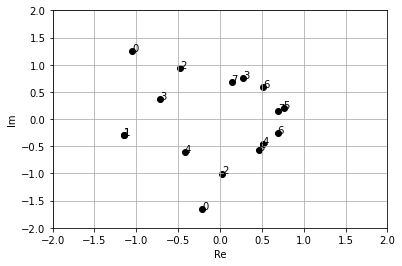

In [109]:
import itertools
def plot_constellation_2(ae, arr, noise_std,  maxrange=None):
        '''Generate a plot of the current constellation'''
        x = ae.transmit(arr, noise_std)
        #marker = itertools.cycle(('1', '2', '3', '4', '^', '6', '7', '8'))
        #weights = [1,4,9,16,25,36,49,64]
        #weights = [1,4,9,16,25,36,49,64,81,100,121,144,169,196,225,256]
        #weights = [1,1,1,1,1,1,1,1]
        #weights = [1,8,27,64,125,216,343,512]
        #weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
        weights = np.arange(M)
        #weights = [1,16,81,256,625, 1296, 2401, 4096]
        #weights = [1,256,6561,65536, 390625, 1.6, 5.7, 16.7]
        #x = ae.transmit(np.ones(ae.M)*n)
        #print(ae.M)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(ae.n_complex):
            
#            image = plt.figure(figsize=(6,6))
            image = plt.plot()
            plt.grid(True)
            plt.xlim(-2,2)
            plt.ylim(-2,2)
            #plt.show() 
            #plt.ion()
            xshape = np.shape(x)
            for i in range(xshape[0]):      
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
                plt.annotate(weights[i], (x[i,k,0],x[i,k,1]))


                #plt.show()              
                #plt.pause(1)
                #plt.hold(True)
            #image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            #image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            #image.suptitle('%d. complex symbol' % (k+1))
            #image.canvas.draw()
            #image.canvas.flush_events()
            
            plt.xlabel('Re')
            plt.ylabel('Im')
            #time.sleep(0.1)
        return x, image

plot_constellation_2(ae,range(0,ae.M), const_noise_std)
#plot_constellation_2(ae_Weighted, range(0, ae_Weighted.M))

**THE RMSE Calculations**

[0 1 0 6 0 0 0 0 4 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 6 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


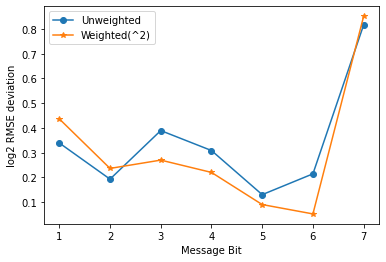

In [120]:
def rmse(predictions,targets):
  return (np.sqrt((np.subtract(predictions,targets) ** 2).mean()))   

tr_hat = ae.end2end(len(tr), tr_noise_std, tr)
tr_hat_w = ae_Weighted.end2end(len(tr), tr_noise_std, tr)
#print(np.shape(tr))
#print(np.shape(tr_hat))
#print(tr)
print(abs(tr_hat - tr))




rmse_uw = {}
for j in range(M):
  rmse_uw[j] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))

rmse_w = {}
for j in range(M):
  rmse_w[j] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))



#message_factor = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,1]
message_factor = (np.arange(M))
message_factor[M-1] = 1
rmse_uwA = []
for i in rmse_uw.values():
  rmse_uwA.append(i)

rmse_wA = []
for i in rmse_w.values():
  rmse_wA.append(i)

#rmse_uwA = rmse_uwA + 1
#rmse_wA = rmse_wA + 1   
#rmse_uw = [rmse_uw_0, rmse_uw_1, rmse_uw_2, rmse_uw_3, rmse_uw_4, rmse_uw_5, rmse_uw_6, rmse_uw_7, rmse_uw_8, rmse_uw_9, rmse_uw_10, rmse_uw_11, rmse_uw_12, rmse_uw_13, rmse_uw_14, rmse_uw_15]
rmse_uw = np.log2(np.divide(rmse_uwA,message_factor) +1 )
#rmse_uw = (np.divide(rmse_uwA,message_factor))
#rmse_uw = rmse_uwA
#rmse_w = [rmse_w_0, rmse_w_1, rmse_w_2, rmse_w_3, rmse_w_4, rmse_w_5, rmse_w_6, rmse_w_7, rmse_w_8, rmse_w_9, rmse_w_10, rmse_w_11, rmse_w_12, rmse_w_13, rmse_w_14, rmse_w_15]
rmse_w = np.log2(np.divide(rmse_wA,message_factor) +1 )
#rmse_w = (np.divide(rmse_wA,message_factor))
#rmse_w = rmse_wA
#message = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
message = np.arange(M)

print(rmse_uw)
plt.plot(message, rmse_uw, '-o');
plt.plot(message, rmse_w, '-*');
plt.xlabel('Message Bit')
plt.ylabel('Normalized RMSE deviation')
plt.ylabel('log2 RMSE deviation')
plt.legend(['Unweighted', 'Weighted(^2)'])


print(np.sum(rmse_uw))
print(np.sum(rmse_w))

print(np.sum(rmse_uwA))
print(np.sum(rmse_wA))

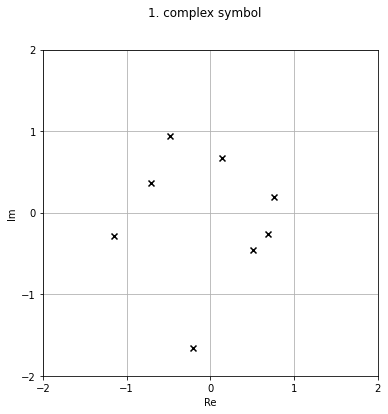

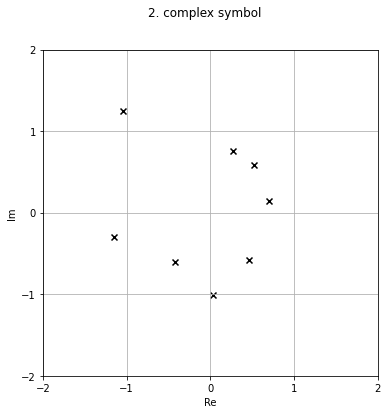

In [111]:
ae.plot_constellation(const_noise_std);
#plot_constellation_2(ae,range(0,ae.M))

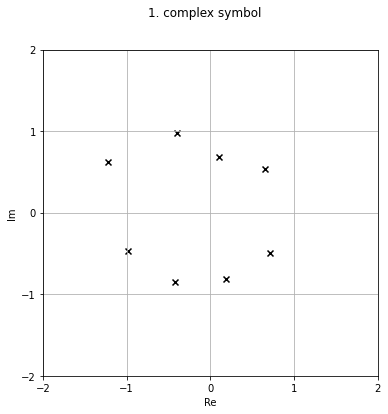

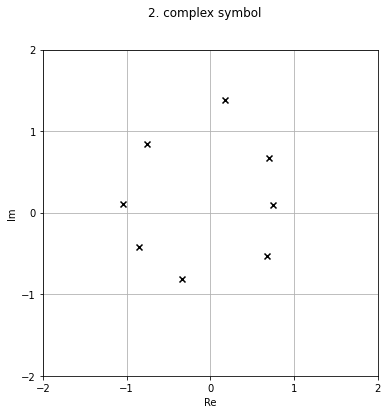

In [112]:
ae_Weighted.plot_constellation(const_noise_std);

In [113]:
# 8-PSK Modulation
#8PSK constellation 
#Demodulation matrx
#Qfunction 

import numpy as np
from scipy import special
import matplotlib.pyplot as plt

import subprocess
import shlex


#Generating constellation points
s = np.zeros((8,2))
s_comp = np.zeros((8,1))+1j*np.zeros((8,1))
for i in range(8):
	s[i,:] = np.array(([np.cos(i*2*np.pi/8),np.sin(i*2*np.pi/8)])) #vector
	s_comp[i] = s[i,0]+1j*s[i,1] #equivalent complex number

#Generating demodulation matrix
A = np.zeros((8,2,2))
A[0,:,:] = np.array(([np.sqrt(2)-1,1],[np.sqrt(2)-1,-1]))
A[1,:,:] = np.array(([np.sqrt(2)+1,-1],[-(np.sqrt(2)-1),1]))
A[2,:,:] = np.array(([-(np.sqrt(2)+1),1],[np.sqrt(2)+1,1]))
A[3,:,:] = np.array(([np.sqrt(2)-1,1],[-(np.sqrt(2)+1),-1]))
A[4,:,:] = np.array(([-(np.sqrt(2)-1),-1],[-(np.sqrt(2)-1),1]))
A[5,:,:] = np.array(([-(np.sqrt(2)+1),1],[np.sqrt(2)-1,-1]))
A[6,:,:] = np.array(([np.sqrt(2)+1,-1],[-(np.sqrt(2)+1),-1]))
A[7,:,:] = np.array(([-(np.sqrt(2)-1),-1],[np.sqrt(2)+1,1]))

#Gray code
gray = np.zeros((8,3))
gray[0,:] = np.array(([0,0,0]))
gray[1,:] = np.array(([0,0,1]))
gray[2,:] = np.array(([0,1,1]))
gray[3,:] = np.array(([0,1,0]))
gray[4,:] = np.array(([1,1,0]))
gray[5,:] = np.array(([1,1,1]))
gray[6,:] = np.array(([1,0,1]))
gray[7,:] = np.array(([1,0,0]))


#Q-function
def qfunc(x):
	return 0.5*special.erfc(x/np.sqrt(2))

In [114]:
def decode(vec_comp):
	vec = np.zeros((2,1))
	vec[0] = np.real(vec_comp)
	vec[1] = np.imag(vec_comp)
	for i in range(8):
		y = A[i,:,:]@vec
		if (y [0] >= 0) and (y[1] >= 0):
			return s_comp[i]

#Extracting bits from demodulated symbols
def detect(vec_comp):
	vec = np.zeros((2,1))
	vec[0] = np.real(vec_comp)
	vec[1] = np.imag(vec_comp)
	for i in range(8):
		if s[i,0]==vec[0] and s[i,1] == vec[1]:
			return gray[i,:]

#Demodulating symbol stream from received noisy  symbols
def rx_symb(mat):
	len = mat.shape[1]
	rx_symb_stream = []
	for i in range(len):
		rx_symb_stream.append(decode(mat[:,i]))
	return rx_symb_stream

#Getting received bit stream from demodulated symbols
def rx_bit(mat):
	len = mat.shape[1]
	rx_bit_stream = []
	for i in range(len):
		rx_bit_stream.append(detect(mat[:,i]))
	return rx_bit_stream

In [115]:
#Generates a bitstream
def bitstream(n):
	return np.random.randint(0,2,n)

#Converts bits to 8-PSK symbols using gray code
def mapping(b0,b1,b2):
	if (b0 == 0 and b1 == 0 and b2 == 0):
		return s[0,:]
	elif (b0 == 0 and b1 == 0 and b2 == 1):
		return s[1,:]
	elif (b0 == 0 and b1 == 1 and b2 == 1):
		return s[2,:]
	elif (b0 == 0 and b1 == 1 and b2 == 0):
		return s[3,:]
	elif( b0 == 1 and b1 == 1 and b2 == 0):
		return s[4,:]
	elif(b0==1 and b1 == 1 and b2 == 1):
		return s[5,:]
	elif(b0==1 and b1 == 0 and b2 == 1):
		return s[6,:]
	elif(b0==1 and b1 == 0 and b2 == 0):
		return s[7,:]


#Converts bitstream to 8-PSK symbol stream
def symb(bits):
	symbol =[]
	i = 0
	while(1):
		try:
			symbol.append(mapping(bits[i],bits[i+1],bits[i+2]))
			i = i+3
		except IndexError:
			return symbol

#Converts bitstream to 8-PSK complex symbol stream
def CompSymb(bits):
	symbols_lst = symb(bits)
	symbols = np.array(symbols_lst).T #Symbol vectors
	symbols_comp = symbols[0,:]+1j*symbols[1,:] #Equivalent complex symbols
	return symbols_comp

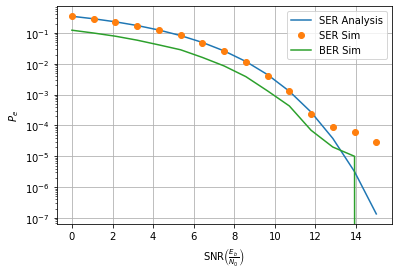

In [116]:

#SNR range
snrlen=15

#SNR in dB and actual per bit 
#(Check Proakis for factor of 6)
snr_db = np.linspace(0,snrlen,snrlen)
snr = 6*10**(0.1*snr_db)

#Bitstream size
bitsimlen = 99999

#Symbol stream size
simlen = bitsimlen //3

#Generating bitstream
bits = bitstream(bitsimlen)

#Converting bits to Gray coded 8-PSK symbols
#Intermediate steps  required for converting list to
#numpy matrix
symbols_lst = symb(bits)
symbols = np.array(symbols_lst).T #Symbol vectors
symbols_comp = symbols[0,:]+1j*symbols[1,:] #Equivalent complex symbols

ser =[]
ser_anal=[]
ber = []

#SNRloop
for k in range(0,snrlen):
	received = []
	t=0
	#Complex noise
	noise_comp = np.random.normal(0,1,simlen)+1j*np.random.normal(0,1,simlen)
	#Generating complex received symbols
  #fade_comp = np.random.normal(0,1,simlen)+1j*np.random.normal(0,1,simlen)
  #fade_comp = np.abs(fade_comp)
  #fade_comp = np.math.sqrt(1/2)*fade_comp
	y_comp = np.sqrt(snr[k])*symbols_comp +noise_comp
	brx = []
	for i in range(simlen):
		srx_comp = decode(y_comp[i]) #Received Symbol
		brx.append(detect(srx_comp))  #Received Bits
		if symbols_comp[i]==srx_comp:
			t+=1; #Counting symbol errors
	#Evaluating SER
	ser.append(1-(t/33334.0))
	ser_anal.append(2*qfunc((np.sqrt(snr[k]))*np.sin(np.pi/8)))
	#Received bitstream
	brx=np.array(brx).flatten()
	#Evaluating BER
	bit_diff = bits-brx
	ber.append(1-len(np.where(bit_diff == 0)[0])/bitsimlen)



#Plots
plt.semilogy(snr_db,ser_anal,label='SER Analysis')
plt.semilogy(snr_db,ser,'o',label='SER Sim')
plt.semilogy(snr_db,ber,label='BER Sim')
plt.xlabel('SNR$\\left(\\frac{E_b}{N_0}\\right)$')
plt.ylabel('$P_e$')
plt.legend()
plt.grid()

### BLER Simulations

In [117]:
ebnodbs = np.linspace(0,14,15)
BLER_8PSK = [0.3478959, 0.2926128, 0.2378847, 0.1854187, 0.1372344, 0.0953536, 0.0614003, 0.0360195, 0.0185215, 0.0082433, 0.0030178, 0.0008626, 0.0001903, 0.0000289, 0.0000027, ]
blers = ae.bler_sim(ad_noise_std, 1000000, 1);
ae.plot_bler(ebnodbs, blers);
blers_w = ae_Weighted.bler_sim(ebnodbs, 1000000, 1);
ae_Weighted.plot_bler(ebnodbs, blers_w);
plt.plot(ebnodbs, blers_w)
plt.semilogy(snr_db,ser,'o')
plt.plot(ebnodbs,BLER_8PSK);
plt.legend(['Autoencoder (Rayleigh+AWGN)', 'Weighted Autoencoder(Rayleigh+AWGN)', 'SER Sim(AWGN)', '8PSK(AWGN)'], prop={'size': 16}, loc='lower left');

ValueError: ignored

In [ ]:
np.divide(10,2)
#IEEE 802.11p Max TX Power 30dBm
#Path loss model corresponding: 20log10(d(m))  (We take n=2, FSPL)
#0.1W corresponds to 20dBm or -10dB
#7dB corresponds to 5W
#IEEE 802.11p is an approved amendment to the IEEE 802.11 standard to add wireless access in vehicular environments (WAVE), a vehicular communication system. 
#IEEE 802.11p standard typically uses channels of 10 MHz bandwidth in the 5.9 GHz band (5.850–5.925 GHz).
# Noise Power -100dBm, TX Power is 20dBm and that \
#256m- -94dBm, 128m- -88dBm, 1m